In [1]:
import torch
import networkx as nx
import torch.optim as optim
import numpy as np
import pickle


In [2]:
# Define or Load graph:

n = 1000  # number of nodes
m = 50000  # number of edges
file_path = "./graphs/er_700-800/ER_700_800_0.15_93.gpickle"

with open(file_path, 'rb') as f:
    G = pickle.load(f)

#nx.draw(G, with_labels=True, font_weight='bold')

In [3]:
# Given Matrix_X and A, count the number of edges connecting the two disjoint sets of the max cut problem

def count_cut_edges(X, adjacency_matrix):
    """
    Count the number of edges connecting elements with 1 and 0 values in X.

    Args:
    - X (torch.Tensor): Torch vector with 0 and 1 values.
    - adjacency_matrix (torch.Tensor): Adjacency matrix of the graph.

    Returns:
    - int: Number of edges connecting elements with 1 and 0 values in X.
    """
    # Convert X to a boolean tensor
    X_bool = X.bool()


    # Find indices of elements with value 1 and 0 in X
    indices_1 = torch.nonzero(X_bool).squeeze()
    indices_0 = torch.nonzero(~X_bool).squeeze()


    # Extract submatrix of adjacency_matrix corresponding to connections between 1s and 0s
    adj_submatrix = adjacency_matrix[indices_1][:, indices_0]

    # Count the number of edges between 1s and 0s
    num_cut_edges = torch.sum(adj_submatrix)

    return num_cut_edges.item()


# Example usage:
X = torch.tensor([1, 0, 1, 1, 0])  # Example torch vector with 0 and 1 values
adjacency_matrix = torch.tensor([[0, 1, 0, 1, 0],
                                 [1, 0, 1, 0, 0],
                                 [0, 1, 0, 1, 1],
                                 [1, 0, 1, 0, 0],
                                 [0, 0, 1, 0, 0]])  # Example adjacency matrix

num_edges = count_cut_edges(X, adjacency_matrix)
print("Number of edges connecting elements with 1 and 0 values in X:", num_edges)


Number of edges connecting elements with 1 and 0 values in X: 3


In [4]:
# Mosek MAx CUt SDP

from mosek.fusion import Model, Domain, ObjectiveSense, Matrix, Expr

# Get the adjacency matrix
A = np.array(nx.adjacency_matrix(G).todense())

# Get the number of nodes and edges
n = len(G.nodes)
number_of_edges = len(G.edges)

# Create a MOSEK model
with Model("SDP_init") as m:

    # Create the matrix variable X
    X = m.variable('X', [n, n], Domain.inPSDCone())

    # Compute the trace of AX
    trace_AX = Expr.dot(A, X)

    #trace_AX = Expr.sum(AX.index(i, i) for i in range(n))
    objective_expr = Expr.sub(0.5 * number_of_edges, Expr.mul(0.5, trace_AX ))

    # Set the objective: maximize the trace of X
    m.objective('obj', ObjectiveSense.Maximize, objective_expr)

    # Add constraints: X_{i,i} == 1 for all i in V
    for node in G.nodes:
        i = node
        m.constraint(f'con_{i}_{i}', X.index(i, i), Domain.equalsTo(1.0))


    # Solve the problem
    m.solve()

    # Get the solution
    X_solution = X.level()
    #X_solution = m.getPrimalSolution()

# Display the results
print("Optimal solution (X):")
print(X_solution)
print(X_solution.shape)
X_solution_reshaped = X_solution.reshape(n, n)
for node in G.nodes:
    print(f"Node {node}: {X_solution_reshaped[node,node]}")

# # double checking symmetry:
# for i in range(n):
#     for j in range(n):
#         if i != j:
#             if X_solution_reshaped[i,j] == X_solution_reshaped[j,i]:
#               print("Symmetric")
#             else:
#               print("Not Symmetric")

Optimal solution (X):
[ 1.          0.52704037 -0.15065602 ...  0.45975625 -0.08876253
  1.        ]
(508369,)
Node 0: 1.0000000000004685
Node 1: 0.9999999999994584
Node 2: 1.0000000000006881
Node 3: 1.0000000000005862
Node 4: 1.000000000001083
Node 5: 1.0000000000006943
Node 6: 0.9999999999994768
Node 7: 1.0000000000005902
Node 8: 1.0000000000002651
Node 9: 0.9999999999994772
Node 10: 0.9999999999991026
Node 11: 0.9999999999991143
Node 12: 0.9999999999994783
Node 13: 1.0000000000010218
Node 14: 1.0000000000007763
Node 15: 0.999999999999611
Node 16: 1.0000000000000446
Node 17: 1.0000000000000708
Node 18: 1.0000000000006861
Node 19: 1.0000000000004496
Node 20: 0.9999999999989092
Node 21: 1.0000000000006524
Node 22: 0.9999999999993712
Node 23: 1.0000000000000735
Node 24: 0.9999999999996069
Node 25: 0.9999999999997768
Node 26: 0.9999999999999217
Node 27: 1.0000000000005225
Node 28: 0.9999999999997785
Node 29: 0.9999999999992963
Node 30: 0.9999999999993933
Node 31: 1.0000000000002829
Node 

In [5]:
# loss function:

adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix_dense = adjacency_matrix.todense()
adjacency_matrix_tensor = torch.tensor(adjacency_matrix_dense, dtype=torch.float32)

# Compute the degree matrix
degree_vector = torch.sum(adjacency_matrix_tensor, dim=1)
degree_matrix = torch.diag(degree_vector)

# Compute the Laplacian matrix
laplacian_matrix = degree_matrix - adjacency_matrix_tensor

def loss_function(laplacian_matrix, Matrix_X):

    ## with edges of the comp graph:
    loss = -(Matrix_X.T @ (laplacian_matrix) @ Matrix_X)
    return loss

In [6]:
# # Spectral Clustering to get the cut from the SDP solution:
# #  A commonly used approach is to select the eigenvector corresponding to the second smallest eigenvalue of the matrix obtained from the SDP solution.
# # This is often referred to as the Fiedler vector.

# # obtaining the eigenvector that correspond to the 2nd smallest eigen value:
# def second_smallest_eigenvector(matrix):
#     # Compute eigenvalues and eigenvectors
#     eigenvalues, eigenvectors = np.linalg.eigh(matrix)

#     # Find the index of the second smallest eigenvalue
#     second_smallest_index = np.argsort(eigenvalues)[1]

#     # Get the corresponding eigenvector
#     second_smallest_eigenvector = eigenvectors[:, second_smallest_index]

#     return second_smallest_eigenvector

# second_smallest_eigenvector = second_smallest_eigenvector(X_solution_reshaped)

# print(second_smallest_eigenvector)

# #Use the signs of the entries of the eigenvectors to partition the vertices of the graph into two sets.
# # If the entry of an eigenvector corresponding to a vertex is positive, put that vertex in one set; if it's negative, put it in the other set.

# # obtain tyhe signs to divide the sets
# SDP_cut = np.sign(second_smallest_eigenvector)
# SDP_cut = SDP_cut+1
# SDP_cut = SDP_cut/2
# print(SDP_cut)

# SDP_cut_value = count_cut_edges(torch.tensor(SDP_cut), adjacency_matrix_tensor)
# print("Number of edges connecting elements with 1 and 0 values from spectral clustering is:", SDP_cut_value)

# node_colors = ['blue' if p == 0 else 'red' for p in SDP_cut]
# nx.draw(G, with_labels=True, node_color=node_colors)

In [7]:
# Next Steps:
#1 How to encode the SDP solution in the quadratic formulation
#2 The restarting mechanism now is when we get a binary vector. I think it would be best to change it to:
# If the value of the cut does not change for 10 iterations, then restart locally for a few iterations, then restart globally

In [10]:
# Optimization loop:

# Initialization:
torch.manual_seed(7)
Matrix_X = torch.rand((n), requires_grad=True)

learning_rate_alpha = 0.01
number_of_iterations_T = 50000

optimizer = optim.Adam([Matrix_X], lr=learning_rate_alpha)
num_edges_buffer = []
best_so_far = 0
for t in range(number_of_iterations_T):

    loss = loss_function(laplacian_matrix, Matrix_X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Box-constraining:
    Matrix_X.data[Matrix_X>=1] =1
    Matrix_X.data[Matrix_X<=0] =0

    thresholded_tensor = (Matrix_X.data > 0).float() # this returns a binary vector to be checked
    #print(thresholded_tensor)
    num_edges = count_cut_edges(thresholded_tensor, adjacency_matrix_tensor)
    num_edges_buffer.append(num_edges)
    if (t + 1) % 50 == 0:
        #print("Iteration:", t, "Loss:", loss.item(), "Number of edges:", num_edges, "Matrix_X:", Matrix_X.data)
        print("Iteration:", t, "Loss:", loss.item(), "Number of edges:", num_edges)

    # # Restart when X becomes binary!! This may not be the best way to restart:
    # is_binary = ((Matrix_X.data == 0) | (Matrix_X.data == 1)).all()
    # if is_binary:
    #     if num_edges > best_so_far: best_so_far = num_edges
    #     torch.manual_seed(t)
    #     Matrix_X = torch.rand((n), requires_grad=True)
    #     optimizer = optim.Adam([Matrix_X], lr=learning_rate_alpha)
    #     print("Restarting...", "Iteration:", t, "Loss:", loss.item(), "Number of edges:", num_edges, "current best: ", best_so_far)

    # Restart when the number of edges does not change for buffer_length iterations
    buffer_len = 20
    if len(set(num_edges_buffer[-buffer_len:])) == 1:
        if num_edges > best_so_far: best_so_far = num_edges
        torch.manual_seed(t)
        Matrix_X = torch.rand((n), requires_grad=True)
        optimizer = optim.Adam([Matrix_X], lr=learning_rate_alpha)
        print("Restarting...", "Iteration:", t, "Loss:", loss.item(), "Number of edges:", num_edges, "current best: ", best_so_far)


Restarting... Iteration: 0 Loss: -6360.10498046875 Number of edges: 211.0 current best:  211.0
Iteration: 49 Loss: -18998.0 Number of edges: 18998.0
Restarting... Iteration: 65 Loss: -18998.0 Number of edges: 18998.0 current best:  18998.0
Iteration: 99 Loss: -17760.837890625 Number of edges: 17819.0
Restarting... Iteration: 133 Loss: -19184.0 Number of edges: 19184.0 current best:  19184.0
Iteration: 149 Loss: -12059.0009765625 Number of edges: 10756.0
Restarting... Iteration: 198 Loss: -19223.0 Number of edges: 19223.0 current best:  19223.0
Iteration: 199 Loss: -6305.845703125 Number of edges: 930.0
Iteration: 249 Loss: -19210.0 Number of edges: 19210.0
Restarting... Iteration: 263 Loss: -19210.0 Number of edges: 19210.0 current best:  19223.0
Iteration: 299 Loss: -18163.47265625 Number of edges: 18070.0
Restarting... Iteration: 327 Loss: -19191.0 Number of edges: 19191.0 current best:  19223.0
Iteration: 349 Loss: -14203.0234375 Number of edges: 13308.0
Restarting... Iteration: 392

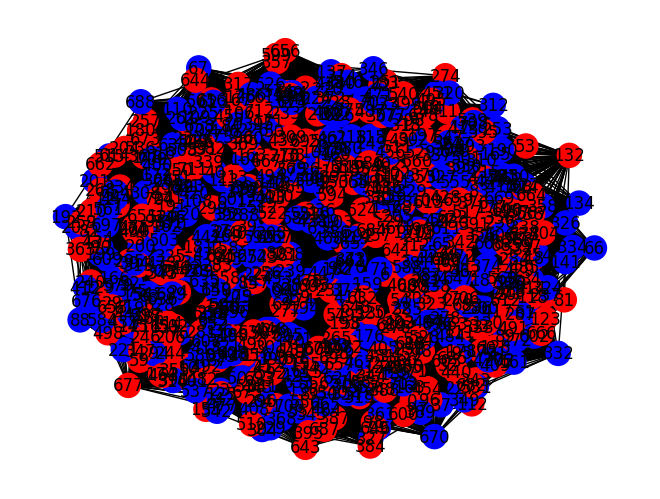

In [9]:
# testing the validity for n = 10 and m = 20
cut = Matrix_X.data
node_colors = ['blue' if p == 0 else 'red' for p in cut]
nx.draw(G, with_labels=True, node_color=node_colors)